In [1]:
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from pycocotools.coco import COCO

from PIL import Image
from pathlib import Path
from matplotlib.patches import Rectangle
from scipy.io import loadmat

import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import models
import random
import re
from collections import Counter
import spacy

import cv2
import matplotlib.pyplot as plt 
from datetime import datetime
from tqdm import tqdm

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [2]:
PATH = Path('data')
ANNOT_PATH = Path('data/annotations')

### COCO utils

In [3]:
def get_caption_index(annot_path, dataset='train', year=2017):
    annot_file = annot_path/f'captions_{dataset}{year}.json'
    return COCO(annot_file)

### Image utils

In [4]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

def crop(im, r, c, target_r, target_c):
    return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

### Sentence encoding utils

In [5]:
vocab2index = pickle.load(open(PATH/'vocab2index.pkl', 'rb'))
index2vocab = pickle.load(open(PATH/'index2vocab.pkl', 'rb'))

In [6]:
re_br = re.compile(r'<\s*br\s*/?>', re.IGNORECASE)
def sub_br(x): return re_br.sub("\n", x)

my_tok = spacy.load('en')
def spacy_tok(x): return [tok.text for tok in my_tok.tokenizer(sub_br(x))]

def encode_sentence_no_padding(s, vocab2index):
    x = spacy_tok(s)
    return np.array([vocab2index.get(w, vocab2index['<unk>']) for w in x])

In [7]:
encode_sentence_no_padding('A boy and a bike in the forest.', vocab2index)

array([  11,  245,   19,   12,   62,   39,    6, 1957, 4476])

### Data

In [8]:
coco_train = get_caption_index(ANNOT_PATH, dataset='train')
coco_val = get_caption_index(ANNOT_PATH, dataset='val')

loading annotations into memory...
Done (t=1.08s)
creating index...
index created!
loading annotations into memory...
Done (t=0.29s)
creating index...
index created!


In [9]:
def get_df(coco_api, dataset, year=2017):
    # dataset should be 'train' or 'val'
    annot_keys = list(coco_api.anns.keys())
    img_ids, img_paths, captions = [], [], []
    for k in tqdm(annot_keys):
        img_id = coco_api.anns[k]['image_id']
        img_ids.append(coco_api.anns[k]['image_id'])
        captions.append(coco_api.anns[k]['caption'])
        filename = coco_api.loadImgs(img_id)[0]['file_name']
        img_paths.append(f'{PATH}/{dataset}{year}_resized/{filename}')
    df = pd.DataFrame({'img_id':img_ids, 'img_path':img_paths, 'caption':captions})
    return df

In [10]:
df_train = get_df(coco_train, 'train')
df_val = get_df(coco_val, 'val')

100%|██████████| 25014/25014 [00:00<00:00, 270189.10it/s]


In [11]:
df_train.head(3)

,img_id,img_path,caption
0,203564,data/train2017_resized/000000203564.jpg,A bicycle replica with a clock as the front wh...
1,322141,data/train2017_resized/000000322141.jpg,A room with blue walls and a white sink and door.
2,16977,data/train2017_resized/000000016977.jpg,A car that seems to be parked illegally behind...


In [12]:
df_val.head(3)

,img_id,img_path,caption
0,179765,data/val2017_resized/000000179765.jpg,A black Honda motorcycle parked in front of a ...
1,179765,data/val2017_resized/000000179765.jpg,A Honda motorcycle parked in a grass driveway
2,190236,data/val2017_resized/000000190236.jpg,An office cubicle with four different types of...


In [13]:
pickle.dump(df_train, open(PATH/'df_train.pkl', 'wb'))
pickle.dump(df_val, open(PATH/'df_val.pkl', 'wb'))

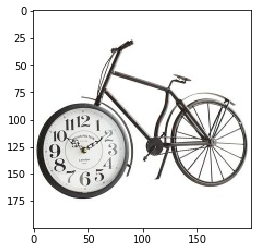

In [14]:
img = read_image(df_train['img_path'][0])
plt.imshow(img); plt.show()

### Dataset

In [15]:
class CocoDataset(Dataset):
    def __init__(self, df, vocab2index, is_test=False, transform=False):
        self.filepaths = df['img_path']
        # Do the encoding on init so we don't have to do it in __getitem__
        self.captions = self.get_encoded_captions(df['caption'], vocab2index)
        self.transform = transform
        self.is_test = is_test
        self.transform = transform
    
    def get_encoded_captions(self, captions, vocab2index):
        captions = list(captions)
        enc_captions = []
        for c in tqdm(captions):
            indices = encode_sentence_no_padding(c, vocab2index)
            indices = [vocab2index['<start>']] + list(indices) + [vocab2index['<end>']]
            indices = np.array(indices)
            enc_captions.append(indices)
        return np.array(enc_captions)

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, index):
        """Return image and encoded caption"""
        
        # Get image, transform if specified
        img = cv2.imread(self.filepaths[index]).astype(np.float32)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255
        if self.transform:
            rdeg = (np.random.random()-.50)*20
            img = rotate_cv(img, rdeg)
            img = random_crop(img)
            if np.random.random() > 0.5: img = np.fliplr(img).copy()
        else:
            img = center_crop(img)
        img = normalize(img)
        img = np.rollaxis(img, 2)
        
        # Get encoded caption
        caption = self.captions[index]
        return img, caption

In [17]:
# train_size = 200000  # TEMP
# val_size = 10000  # TEMP

In [31]:
train_ds = CocoDataset(df_train, vocab2index, transform=True)

100%|██████████| 591753/591753 [02:40<00:00, 3678.48it/s]


In [32]:
pickle.dump(train_ds, open(PATH/'train_ds.pkl', 'wb'))

In [33]:
valid_ds = CocoDataset(df_val, vocab2index)

100%|██████████| 25014/25014 [00:06<00:00, 3731.70it/s]


In [34]:
pickle.dump(valid_ds, open(PATH/'valid_ds.pkl', 'wb'))

In [35]:
train_ds = pickle.load(open(PATH/'train_ds.pkl', 'rb'))
valid_ds = pickle.load(open(PATH/'valid_ds.pkl', 'rb'))

### Collate function

In [36]:
def collate_fn(data):
    """Creates mini-batch tensors from the list of tuples (sentences, labels).
    
    Need custom collate_fn because merging sequences (including padding) is not 
    supported in default. Sequences are padded to the maximum length of mini-batch 
    sequences (dynamic padding).
    
    Args:
        data: list of tuple (sentence, label). 
            - list of word indices of variable length
            - label, 0 or 1
    Returns:
        packed_batch: (PackedSequence), see torch.nn.utils.rnn.pack_padded_sequence
        sencences: torch tensor of shape (batch_size, max_len).
        labels: torch tensor of shape (batch_size, 1).
        lengths: list; valid length for each padded sentence. 
    """
    # Sort a data list by sentences length (descending order).
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)
    
    # Merge images
    images = torch.Tensor(np.stack(images, 0))
    
    # Merge sentences
    lengths = [len(s) for s in captions]
    captions_padded = torch.zeros(len(captions), max(lengths)).long()
    for i, c in enumerate(captions):
        end = lengths[i]
        captions_padded[i, :end] = torch.Tensor(c[:end])        
    
    return images, lengths, captions_padded

In [37]:
# Sanity check

batch_size = 5
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, collate_fn=collate_fn)

In [38]:
next(iter(train_dl))[0].shape

torch.Size([5, 3, 184, 184])

## Models

In [39]:
class Encoder(nn.Module):
    def __init__(self, emb_dim):
        super(Encoder, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])  # Blocks 1-6
        self.features2 = nn.Sequential(*layers[6:])  # Blocks 7-8
        self.pool = nn.AdaptiveAvgPool2d((1,1))  # 1 pooling layer
        self.linear = nn.Linear(resnet.fc.in_features, emb_dim)  # we have to pass this vector to LSTM
        self.bn = nn.BatchNorm1d(emb_dim, momentum=0.01)
        
    def forward(self, x):
        x = self.features1(x)  # pass through first 6 layers
        x = self.features2(x)  # pass through last 2 layers
        x = F.relu(x)  # activation
        x = self.pool(x)
        x = x.view(x.shape[0], -1)
        x = self.linear(x)
        x = self.bn(x)
        return x

In [40]:
class Decoder(nn.Module):
    def __init__(self, emb_dim, vocab_size, hidden_dim, num_layers,
                 glove_weights=None, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(Decoder, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        if glove_weights is not None:
            self.emb.weight.data.copy_(torch.from_numpy(glove_weights))
#             self.emb.weight.requires_grad = False  # freeze embeddings
        self.lstm = nn.LSTM(emb_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.emb(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hidden, _ = self.lstm(packed)
        outputs = self.linear(hidden[0])
#         out_pack, (ht, ct) = self.lstm(packed)
#         outputs = self.linear(ht[-1])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_dim)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.emb(predicted)                       # inputs: (batch_size, emb_dim)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, emb_dim)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

## Training

In [41]:
sf = SmoothingFunction()

In [42]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [43]:
def val_metrics(encoder, decoder, valid_dl, debug=False):
    encoder.eval()
    decoder.eval()
    sum_loss = 0
    sum_bleu = 0
    bleu_scores = []
    total = 0
    
    for images, lengths, captions in valid_dl:
        batch_size = len(lengths)
        images = images.cuda().float()
        captions = captions.cuda()
        labels = pack_padded_sequence(captions, lengths, batch_first=True)[0]
        
        # Forward
        features = encoder(images)  # Get image features (last layer output of encoder)
        out = decoder(features, captions, lengths)  # Get predicted words
        
        # Compute BLEU-4 score
        features = encoder(images)  # get feature vectors
        sampled_ids = decoder.sample(features).cpu().numpy()
        predicted_words = np.array([np.array([index2vocab[idx] for idx in pred]) for pred in sampled_ids])
        captions = captions.cpu().numpy()
        actual_words = np.array([np.array([index2vocab[idx] for idx in c]) for c in captions])

        for i, (actual, predicted) in enumerate(zip(actual_words, predicted_words)):
            bleu_single = sentence_bleu(list(actual), list(predicted),
                                       smoothing_function=sf.method1)
            #print(bleu_single)
            sum_bleu += bleu_single
            bleu_scores.append(bleu_single)
        
#         if debug:
#             actual = actual_words[-1]
#             predicted = predicted_words[-1]
#             bleu_single = sentence_bleu(list(actual), list(predicted),
#                           smoothing_function=sf.method1)
#             print(f'Actual:\n{list(actual)}')
#             print(f'Predicted:\n{list(predicted)}')
#             print(f'This BLEU: {bleu_single}')
#             print('-' * 50)
        
        loss = F.cross_entropy(out, labels)
        sum_loss += batch_size * (loss.item())
        total += batch_size

    if debug:
        #print(f'BLEU score max: {bleu_scores}, BLEU score min: {bleu_scores}')
        print(f'BLEU score max: {np.max(bleu_scores)}, BLEU score min: {np.min(bleu_scores)}')
        print(f'Sum BLEU: {round(sum_bleu,10)}, Total: {total}, Avg BLEU: {round(sum_bleu/total,10)}')
    return sum_loss/total, sum_bleu/total

In [47]:
def train_epochs(encoder, decoder, optimizer, train_dl, valid_dl, epochs=10):
    for i in range(epochs):
        encoder.train()
        decoder.train()
        sum_loss = 0.0
        total = 0
        curr_loss = np.Inf
        num_batches = len(train_dl)
        
        for i, (images, lengths, captions) in enumerate(tqdm(train_dl)):
            batch_size = len(lengths)
            images = images.cuda().float()
            captions = captions.cuda()
            labels = pack_padded_sequence(captions, lengths, batch_first=True)[0]
            
            # Forward
            features = encoder(images)  # Get image features (last layer output of encoder)
            out = decoder(features, captions, lengths)  # Get predicted words
            
            # Loss, backward
            loss = F.cross_entropy(out, labels)
            decoder.zero_grad()
            encoder.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Tally
            total += batch_size
            sum_loss += loss.item()
            
#             if i % 100 == 0:
#                 print(f'Processed batch {i}/{num_batches}')
            
        # Metrics
        train_loss = sum_loss / total
        val_loss, val_bleu = val_metrics(encoder, decoder, valid_dl, debug=True)
        print(val_bleu)
        print("train_loss %.3f val_loss %.3f val_bleu %.10f" % (train_loss, val_loss, val_bleu))
        if val_loss < curr_loss:
            curr_loss = val_loss
            enc_path = f"{PATH}/models/model_encoder_resnet34_bleu_{round(val_bleu, 10)}.pth"
            dec_path = f"{PATH}/models/model_decoder_bleu_{round(val_bleu, 10)}.pth"
            save_model(encoder, enc_path)
            save_model(decoder, dec_path)
            print(enc_path, dec_path)
            
    return sum_loss / total

In [48]:
glove_weights = pickle.load(open(PATH/'pretrained_weights.pkl', 'rb'))
embed_dim = 50  # we're using glove 50d embeddings
vocab_size = len(vocab2index)
hidden_dim = 20
num_layers = 2

encoder = Encoder(embed_dim).cuda()
decoder = Decoder(embed_dim, vocab_size, hidden_dim, num_layers,
                  glove_weights=glove_weights).cuda()

batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                      collate_fn=collate_fn, num_workers=2)
valid_dl = DataLoader(valid_ds, batch_size=batch_size,
                      collate_fn=collate_fn, num_workers=2)

params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=0.01)

In [49]:
train_epochs(encoder, decoder, optimizer, train_dl, valid_dl) #lr 0.01 batch_size 32

  0%|          | 0/18493 [00:00<?, ?it/s]

BLEU score max: 0.014400124446705301, BLEU score min: 0.0
Sum BLEU: 293.4605933234, Total: 25014, Avg BLEU: 0.0117318539
0.011731853894755288
train_loss 0.101 val_loss 2.885 val_bleu 0.0117318539
data/models/model_encoder_resnet34_bleu_0.0117318539.pth data/models/model_decoder_bleu_0.0117318539.pth


  0%|          | 0/18493 [00:00<?, ?it/s]

BLEU score max: 0.014400124446705301, BLEU score min: 0.0
Sum BLEU: 296.1709627859, Total: 25014, Avg BLEU: 0.011840208
0.011840207994957153
train_loss 0.089 val_loss 2.811 val_bleu 0.0118402080
data/models/model_encoder_resnet34_bleu_0.011840208.pth data/models/model_decoder_bleu_0.011840208.pth


  0%|          | 0/18493 [00:00<?, ?it/s]

BLEU score max: 0.014400124446705301, BLEU score min: 0.0
Sum BLEU: 292.7488071941, Total: 25014, Avg BLEU: 0.0117033984
0.011703398384667808
train_loss 0.087 val_loss 2.788 val_bleu 0.0117033984
data/models/model_encoder_resnet34_bleu_0.0117033984.pth data/models/model_decoder_bleu_0.0117033984.pth


  0%|          | 0/18493 [00:00<?, ?it/s]

BLEU score max: 0.014400124446705301, BLEU score min: 0.0
Sum BLEU: 295.0610008858, Total: 25014, Avg BLEU: 0.0117958344
0.01179583436818481
train_loss 0.087 val_loss 2.772 val_bleu 0.0117958344
data/models/model_encoder_resnet34_bleu_0.0117958344.pth data/models/model_decoder_bleu_0.0117958344.pth


  0%|          | 0/18493 [00:00<?, ?it/s]

BLEU score max: 0.014400124446705301, BLEU score min: 0.0
Sum BLEU: 295.5888108371, Total: 25014, Avg BLEU: 0.0118169349
0.011816934949911971
train_loss 0.086 val_loss 2.764 val_bleu 0.0118169349
data/models/model_encoder_resnet34_bleu_0.0118169349.pth data/models/model_decoder_bleu_0.0118169349.pth


  0%|          | 0/18493 [00:00<?, ?it/s]

BLEU score max: 0.014400124446705301, BLEU score min: 0.0
Sum BLEU: 293.7740055824, Total: 25014, Avg BLEU: 0.0117443834
0.011744383368607928
train_loss 0.086 val_loss 2.753 val_bleu 0.0117443834
data/models/model_encoder_resnet34_bleu_0.0117443834.pth data/models/model_decoder_bleu_0.0117443834.pth


  0%|          | 0/18493 [00:00<?, ?it/s]

BLEU score max: 0.014400124446705301, BLEU score min: 0.0
Sum BLEU: 294.4602420943, Total: 25014, Avg BLEU: 0.0117718175
0.011771817465989138
train_loss 0.086 val_loss 2.751 val_bleu 0.0117718175
data/models/model_encoder_resnet34_bleu_0.0117718175.pth data/models/model_decoder_bleu_0.0117718175.pth


  0%|          | 0/18493 [00:00<?, ?it/s]

BLEU score max: 0.014400124446705301, BLEU score min: 0.0
Sum BLEU: 294.9267636118, Total: 25014, Avg BLEU: 0.0117904679
0.011790467882457375
train_loss 0.086 val_loss 2.746 val_bleu 0.0117904679
data/models/model_encoder_resnet34_bleu_0.0117904679.pth data/models/model_decoder_bleu_0.0117904679.pth


  0%|          | 0/18493 [00:00<?, ?it/s]

BLEU score max: 0.014400124446705301, BLEU score min: 0.0
Sum BLEU: 294.7227134259, Total: 25014, Avg BLEU: 0.0117823104
0.011782310443189115
train_loss 0.086 val_loss 2.753 val_bleu 0.0117823104
data/models/model_encoder_resnet34_bleu_0.0117823104.pth data/models/model_decoder_bleu_0.0117823104.pth


100%|██████████| 18493/18493 [1:27:20<00:00,  3.53it/s]


BLEU score max: 0.014400124446705301, BLEU score min: 0.0
Sum BLEU: 294.7251777582, Total: 25014, Avg BLEU: 0.011782409
0.011782408961310458
train_loss 0.085 val_loss 2.749 val_bleu 0.0117824090
data/models/model_encoder_resnet34_bleu_0.011782409.pth data/models/model_decoder_bleu_0.011782409.pth


0.08545088111516544

---
### Scratch

In [40]:
# Scratch

batch = next(iter(train_dl))
images, lengths, captions = batch

images = images.cuda()
captions = captions.cuda()

features = encoder(images.cuda())
out = decoder(features, captions, lengths) 
pack = pack_padded_sequence(captions, lengths, batch_first=True)

F.cross_entropy(out, pack[0])

out.shape, pack[0].shape, pack[1].shape

(torch.Size([856, 24182]), torch.Size([856]), torch.Size([21]))

In [157]:
# Calculating BLEU scores - example
batch_size = 5
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, collate_fn=collate_fn)

In [159]:
images, lengths, captions = next(iter(train_dl))
images = images.cuda().float()
captions = captions.cuda()

In [160]:
features = encoder(images)  # get feature vectors
sampled_ids = decoder.sample(features).cpu().numpy()
predicted_words = np.array([np.array([index2vocab[idx] for idx in pred]) for pred in sampled_ids])
captions = captions.cpu().numpy()
actual_words = np.array([np.array([index2vocab[idx] for idx in c]) for c in captions])

In [162]:
predicted_words

array([['<end>', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.',
        '.', '.', '.', '.', '.', '.', '.', '.'],
       ['four', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.',
        '.', '.', '.', '.', '.', '.', '.', '.'],
       ['<end>', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.',
        '.', '.', '.', '.', '.', '.', '.', '.'],
       ['<end>', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.',
        '.', '.', '.', '.', '.', '.', '.', '.'],
       ['people', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.',
        '.', '.', '.', '.', '.', '.', '.', '.']], dtype='<U6')

In [161]:
actual_words

array([['<start>', 'Two', 'silver', 'motorcycles', 'on', 'a', 'parking',
        'lot', 'with', 'people', 'in', 'the', 'background', '.', '<end>'],
       ['<start>', 'A', 'bathroom', 'with', 'a', 'toilet', 'and', 'a',
        'bathtub', 'with', 'a', 'safety', 'rail', '.', '<end>'],
       ['<start>', 'A', 'white', 'cat', 'sits', 'on', 'the', 'floor',
        'beside', 'a', 'brown', 'towel', '.', '<end>', '<pad>'],
       ['<start>', 'Motorcycle', ',', 'automobile', 'and', 'pedestrian',
        'traffic', 'on', 'a', 'city', 'street', '.', '<end>', '<pad>',
        '<pad>'],
       ['<start>', 'A', 'corner', 'in', 'a', 'kitchen', 'with', 'many',
        'potted', 'plants', '.', '<end>', '<pad>', '<pad>', '<pad>']],
      dtype='<U11')

In [172]:
sf = SmoothingFunction()
bleu =sentence_bleu(list(actual_words[0]), list(predicted_words[0]),
              smoothing_function=sf.method1)
round(35.2535, 3)

35.254